# Reservoir Computing Demo

> Author: Kai Chen

## Install requirements and load dependencies

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
import seaborn as sns
# import pandas as pd
# from scipy.ndimage import gaussian_filter1d

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Formulism of reservoir computing

![rc_graph](rc_graph.png)

The dynamics of the recurrent reservoir network is described the ODE below: 
$$
\tau\frac{d}{dt}x_i(t) = -x_i(t) + \sum_j J_{ij} r_j(t) + I_{ext}(t)
$$

where $x_i(t)$ is the state of i-th node and $r_j(t)$ is the activateion (firing rate) of j-th node as defined below

$$
r_j(t) = \tanh x_j(t).
$$

And the output $y(t)$ of the network is conducted by a linear decoder with weight $\mathbf{w}$, defined below 

$$
y(t) = \mathbf{w}^T\mathbf{r}(t).
$$

In the framework of reservoir computing, the only trainable parameters are decoder weights, $\mathbf{w}$, which can be trained by gradient based algorithm or least square, with respect to the objective below

$$
\mathcal{L}(w) = \int_t \left|y(t)-I_{ext}(t)\right|^2 dt = \int_t \left|\mathbf{w}^T\mathbf{r}(t)-I_{ext}(t)\right|^2 dt 
$$

In [2]:
# numerically solve the ODE
N = 100
tau = 1
p = 0.1 # sparsity of J
g = 0.9 # spectra radius of J
np.random.seed(0)
J = g/np.sqrt(p*N)*np.random.randn(N,N) * (np.random.rand(N,N)<p)
# J = g/np.sqrt(N)*(np.random.rand(N,N)-0.5)*2
W_in = np.random.randn(N,1)

Text(0, 0.5, 'Im(Eigenvalue)')

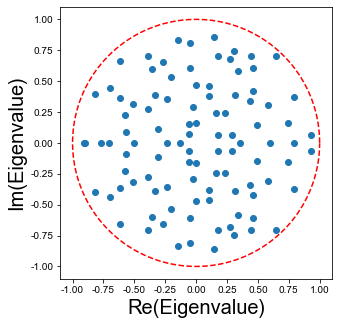

In [3]:
# plot the spectrum of J
eig,_ = np.linalg.eig(J)
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(np.real(eig), np.imag(eig))
ax.plot(np.cos(np.arange(0,np.pi*2, 0.01)), np.sin(np.arange(0,np.pi*2, 0.01)), 'r--')
ax.axis('scaled')
ax.set_xlabel('Re(Eigenvalue)', fontsize=20)
ax.set_ylabel('Im(Eigenvalue)', fontsize=20)

## Build model of reservoir network

In [4]:
class RNN(torch.nn.Module):
    def __init__(self, N):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            1, N, 1, 
            nonlinearity='tanh',
            bias=False,
        )
        self.h = torch.randn(1, 1, N)
        self.linear = nn.Linear(N, 1, bias=False)
        # set param of reservoir network untrainable
        for pm in self.rnn.parameters():
            pm.requires_grad=False

    def forward(self, x):
        rnn_output, hn = self.rnn(x, self.h)
        target = self.linear(rnn_output)
        self.h = hn
        return target


Train the model with Gaussian white noise.

In [5]:
torch.manual_seed(0)
input = torch.randn(1000, 1, 1)
output = input.clone()

rnn = RNN(100)
rnn.rnn.weight_hh_l0 = nn.Parameter(torch.Tensor(J))
rnn.rnn.weight_ih_l0 = nn.Parameter(torch.Tensor(W_in))
rnn.rnn.weight_hh_l0.requires_grad=False
rnn.rnn.weight_ih_l0.requires_grad=False
loss_fn = nn.MSELoss()
optimizer=torch.optim.Adam(rnn.parameters(), lr=0.1)

for _ in range(100):
    pred = rnn(input)
    loss = loss_fn(pred, output)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Test the model with Gaussian white noise.

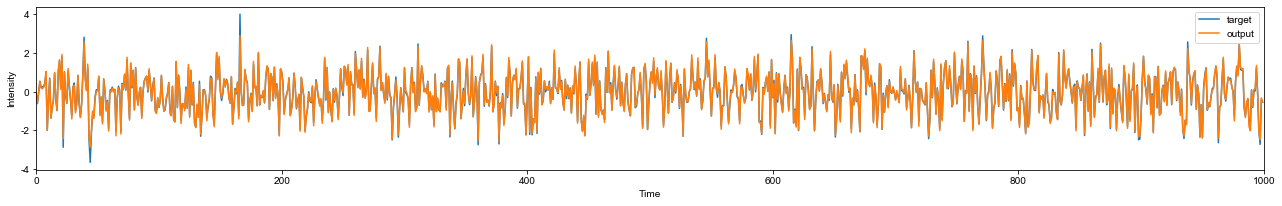

In [6]:
def test_model(model, test_input, target, ax=None):
    test_input = test_input.reshape((-1,1,1))
    pred = model(test_input)
    if ax is None:
        fig, ax =plt.subplots(1,1,figsize=(22,3))
    ax.plot(target.flatten(), label='target')
    ax.plot(pred.detach().flatten(), label='output')
    ax.set_xlim(0, target.flatten().shape[0])
    ax.set_xlabel('Time')
    ax.set_ylabel('Intensity')
    ax.legend()


test_input = torch.randn(1000, 1, 1)
test_model(rnn, test_input, test_input)

Test with sine wave.

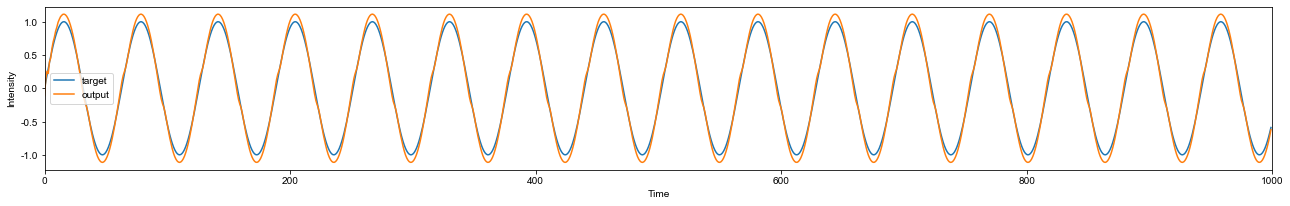

In [7]:
test_input = torch.sin(torch.arange(0,100,0.1))
test_model(rnn, test_input, test_input)

Test with noisy sine wave.

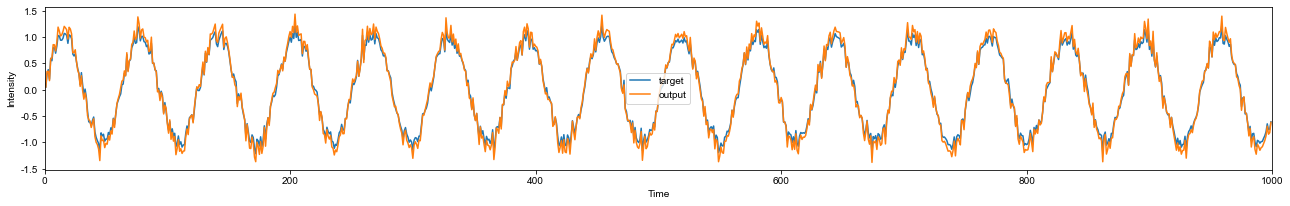

In [8]:
test_input = torch.sin(torch.arange(0,100,0.1))
test_input += torch.randn(test_input.shape[0])*.1
test_model(rnn, test_input, test_input)